# Objective
* 20190102: 
    * Predict stock price in next day using long short term memory(LSTM)
    * Given prices for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190120 - Diff from SotckPricePrediction_v4_lstm.ipynb: 
    * Instead of MinMaxScaler, here we use StandardScaler
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader as dr
import tensorflow
import random

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.



fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
random.seed(13)

Using TensorFlow backend.


# Common functions

In [2]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Load data

In [3]:
df = dr.get_data_yahoo('CBOM.ME')

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,high,low,open,close,volume,adj_close,date,month
Date,,,,,,,,
2015-07-01,3.70647,3.59151,3.59448,3.64700,22199552.0,3.579847,2015-07-01,7
2015-07-02,3.76593,3.59151,3.76593,3.61281,27957072.0,3.546287,2015-07-02,7
2015-07-03,3.69160,3.59894,3.69160,3.60439,38557012.0,3.538022,2015-07-03,7
2015-07-06,3.63709,3.60736,3.60786,3.63709,8483465.0,3.570120,2015-07-06,7
2015-07-07,3.76593,3.59844,3.76593,3.59844,30759598.0,3.532182,2015-07-07,7


Text(0, 0.5, 'RUB')

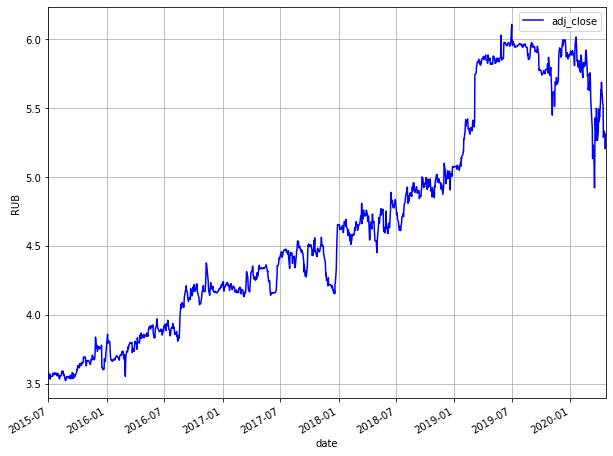

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("RUB")

# Split into train, dev and test sets

We use lags up to N number of days to use as features.

In [5]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 729
num_cv = 242
num_test = 242
train.shape = (729, 2)
cv.shape = (242, 2)
train_cv.shape = (971, 2)
test.shape = (242, 2)


In [6]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [4.11242595]
scaler.var_ = [0.12568356]
x_train_scaled.shape = (726, 3, 1)
y_train_scaled.shape = (726, 1)


In [7]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (242, 3, 1)
y_cv.shape = (242, 1)
len(mu_cv_list) = 242
len(std_cv_list) = 242


In [8]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [4.3627501]
scaler_final.var_ = [0.32060549]


# Create and fit the LSTM network

In [9]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0465


In [10]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Plot model and save to file
#from IPython.display import SVG
#from keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot

#plot_model(model, to_file='model_v4a.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Predict on dev set

In [12]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (242, 1)
RMSE = 0.057
MAPE = 0.757%


Text(0, 0.5, 'USD')

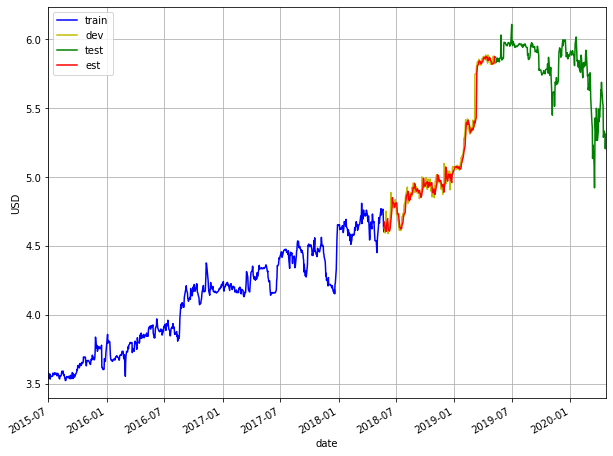

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Tuning N (no. of days to use as features)

In [14]:
param_label = 'N'
param_list = range(3, 10)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.3529709657033285


,N,rmse,mape_pct
0,3,0.055035,0.726870
1,4,0.059935,0.788929
2,5,0.064191,0.840931
3,6,0.066186,0.850304
4,7,0.067514,0.874654
5,8,0.067543,0.872465
6,9,0.070319,0.897040


Text(0, 0.5, 'RMSE/MAPE(%)')

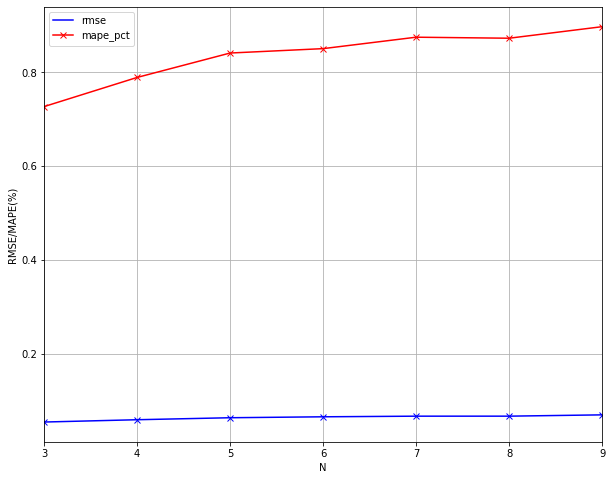

In [15]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [16]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.055
min MAPE = 0.727%
optimum N = 3


# Tuning model - epochs and batch_size

In [17]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



Minutes taken = 1.5056147257486978


,epochs,batch_size,rmse,mape_pct
0,1,8,0.057676,0.765109
1,1,16,0.059975,0.794423
2,1,32,0.052502,0.688573
3,1,64,0.051286,0.674373
4,1,128,0.050813,0.668011
5,10,8,0.053679,0.706978
6,10,16,0.056092,0.739662
7,10,32,0.057034,0.752907
8,10,64,0.057499,0.760999
9,10,128,0.056655,0.747690


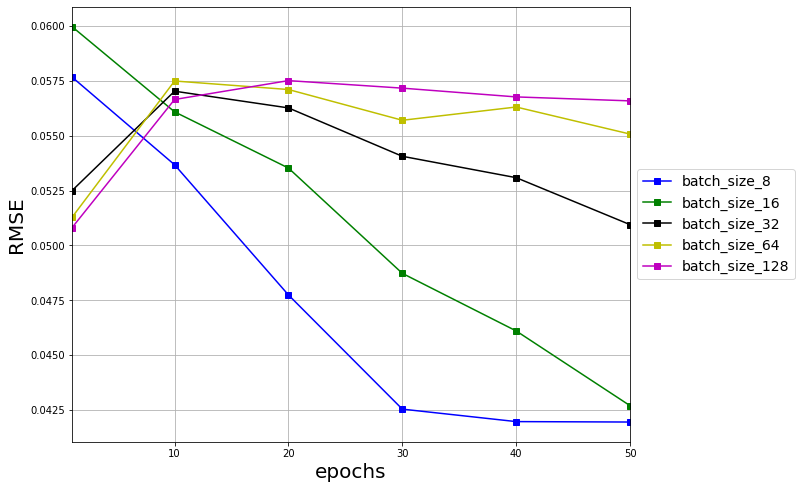

In [18]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label, fontsize = 20)
ax.set_ylabel("RMSE", fontsize = 20)
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [19]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 0.042
min MAPE = 0.553%
optimum epochs = 50
optimum batch_size = 8


# Tuning model - LSTM units and dropout prob

In [20]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



Minutes taken = 4.771349545319875


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,0.054508,0.716196
1,10,0.6,0.055804,0.734754
2,10,0.7,0.056544,0.745930
3,10,0.8,0.056907,0.748078
4,10,0.9,0.053576,0.703130
5,10,1.0,0.046029,0.608380
6,50,0.5,0.048357,0.635152
7,50,0.6,0.050269,0.662710
8,50,0.7,0.052322,0.687901
9,50,0.8,0.056381,0.741355


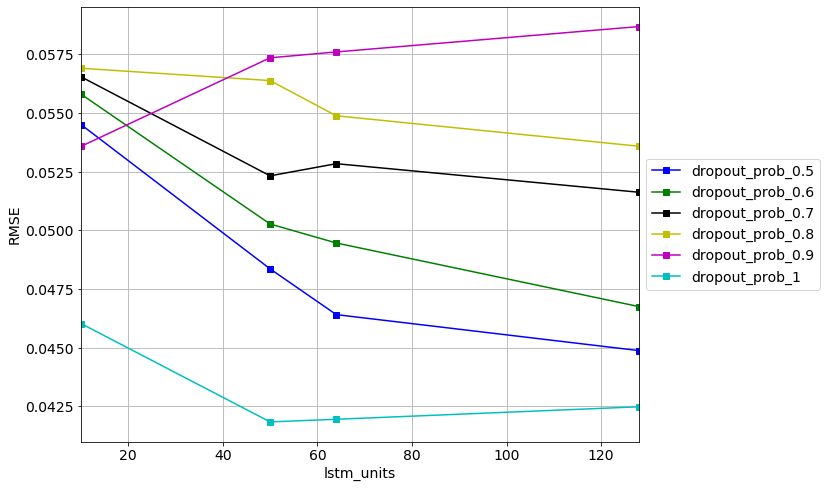

In [21]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [22]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 0.042
min MAPE = 0.552%
optimum lstm_units = 50
optimum dropout_prob = 1.0


# Tuning model - optimizer

In [23]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 1.1809696435928345


,optimizer,rmse,mape_pct
0,adam,0.041937,0.553131
1,sgd,0.054196,0.711206
2,rmsprop,0.041911,0.553820
3,adagrad,0.048702,0.641544
4,adadelta,0.042211,0.559726
5,adamax,0.042164,0.558558
6,nadam,0.042319,0.564858


Text(0, 0.5, 'RMSE/MAPE(%)')

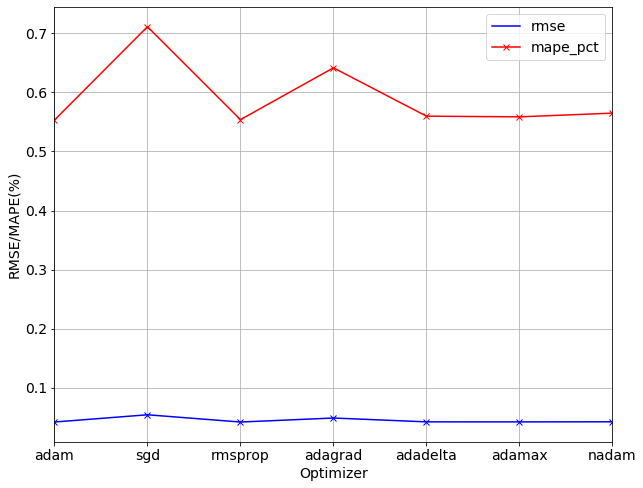

In [24]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [25]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.042
min MAPE = 0.553%
optimum optimizer = rmsprop


# Tuned params

In [39]:
d = {'параметр': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'исходный вариант': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'после настройки': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,параметр,исходный вариант,после настройки
0,N,3,3
1,lstm_units,50,50
2,dropout_prob,1,1
3,optimizer,adam,rmsprop
4,epochs,1,50
5,batch_size,1,8
6,rmse,0.0574201,0.0419105
7,mape_pct,0.756746,0.553131


# Final model

In [27]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.065
MAPE on test set = 0.710%


Text(0, 0.5, 'CBOM share price, RUB')

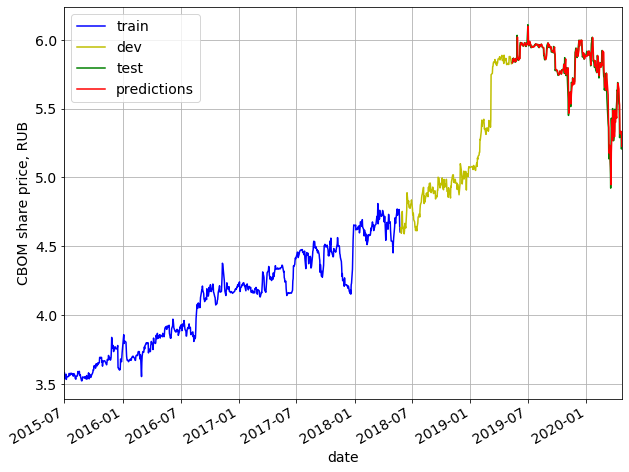

In [41]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("CBOM share price, RUB")

Text(0.5, 1.0, 'Zoom in to test set')

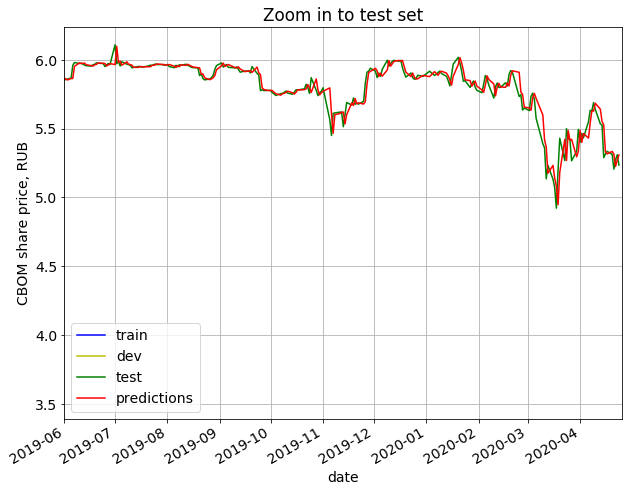

In [43]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("CBOM share price, RUB")
ax.set_xlim([date(2019, 6, 1), date(2020, 4, 26)])
#ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

Text(0, 0.5, 'RUB')

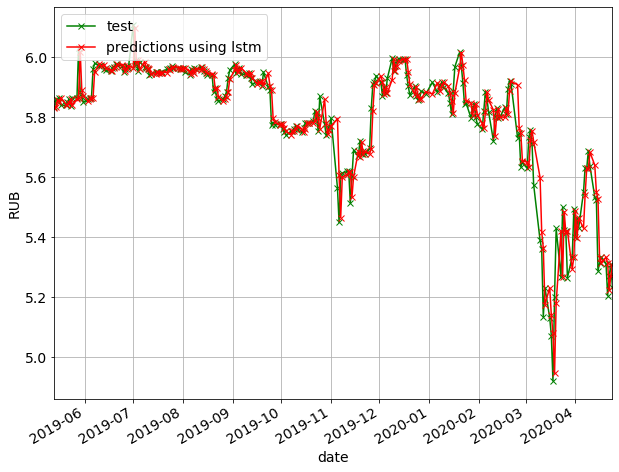

In [30]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("RUB")
#ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])

In [31]:
# Save as csv
test_lstm = est_df
#test_lstm.to_csv("test_lstm1.csv")

# Findings
* On the test set, the RMSE is 1.164 and MAPE is 0.583% using N_opt=3

In [32]:
est_df = pd.merge(est_df, test, on = 'Date')

In [33]:
est_df.drop(['date_x', 'date_y'], axis=1, inplace=True)

In [34]:
est_df.rename(columns={"adj_close":"y_sample"}, inplace = True)

In [35]:
pnl_data = est_df

In [36]:
pnl_data["position"] = ""

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
for i in range(0,len(pnl_data)):
    if pnl_data.iloc[i+1,0] > pnl_data.iloc[i,0]:
        pnl_data.iloc[i,2] = 1
    else:
        pnl_data.iloc[i,2] = -1

IndexError: single positional indexer is out-of-bounds

In [46]:
pnl_data

,est,y_sample,position
Date,,,
2019-05-13,5.831901,5.833570,1
2019-05-14,5.833598,5.860074,1
2019-05-15,5.858582,5.854184,-1
2019-05-16,5.853213,5.865963,1
2019-05-17,5.865074,5.841424,-1
...,...,...,...
2020-04-20,5.334294,5.313000,-1
2020-04-21,5.315150,5.206000,-1
2020-04-22,5.225083,5.273000,1


In [47]:
pnl_data["expected_difference_in_prices"] = pnl_data.shift(-1, axis = 0)["est"] - pnl_data["est"] 

In [48]:
pnl_data["daily_pnl"] = pnl_data["position"]*pnl_data["expected_difference_in_prices"]

In [49]:
pnl_data

,est,y_sample,position,expected_difference_in_prices,daily_pnl
Date,,,,,
2019-05-13,5.831901,5.833570,1,0.001697,0.00169717
2019-05-14,5.833598,5.860074,1,0.024984,0.0249844
2019-05-15,5.858582,5.854184,-1,-0.005369,0.00536914
2019-05-16,5.853213,5.865963,1,0.011861,0.0118612
2019-05-17,5.865074,5.841424,-1,-0.019389,0.0193885
...,...,...,...,...,...
2020-04-20,5.334294,5.313000,-1,-0.019144,0.0191441
2020-04-21,5.315150,5.206000,-1,-0.090067,0.0900666
2020-04-22,5.225083,5.273000,1,0.047298,0.0472979


In [50]:
pnl_data['daily_pnl'] = pnl_data['daily_pnl'].fillna(0)
pnl_data['expected_difference_in_prices'] = pnl_data['expected_difference_in_prices'].fillna(0)

In [51]:
pnl_data['coef_for_pnl'] = pnl_data['daily_pnl'] + 1

In [52]:
pnl_data["cumulative_pnl"] = pnl_data.daily_pnl.cumsum()
pnl_data["cumulative_pnl_prod"] = pnl_data.coef_for_pnl.cumprod()

In [53]:
pnl_data

,est,y_sample,position,expected_difference_in_prices,daily_pnl,coef_for_pnl,cumulative_pnl,cumulative_pnl_prod
Date,,,,,,,,
2019-05-13,5.831901,5.833570,1,0.001697,0.001697,1.001697,0.001697,1.001697
2019-05-14,5.833598,5.860074,1,0.024984,0.024984,1.024984,0.026682,1.026724
2019-05-15,5.858582,5.854184,-1,-0.005369,0.005369,1.005369,0.032051,1.032237
2019-05-16,5.853213,5.865963,1,0.011861,0.011861,1.011861,0.043912,1.044480
2019-05-17,5.865074,5.841424,-1,-0.019389,0.019389,1.019389,0.063300,1.064731
...,...,...,...,...,...,...,...,...
2020-04-20,5.334294,5.313000,-1,-0.019144,0.019144,1.019144,8.532072,3503.772147
2020-04-21,5.315150,5.206000,-1,-0.090067,0.090067,1.090067,8.622139,3819.345080
2020-04-22,5.225083,5.273000,1,0.047298,0.047298,1.047298,8.669437,3999.992141


In [54]:
portfolio = pd.DataFrame(pnl_data["daily_pnl"])

Start date,2019-05-13
End date,2020-04-24
Total months,11
,Backtest
Annual return,584616.6%
Cumulative returns,414341.7%
Annual volatility,72.9%
Sharpe ratio,12.44
Calmar ratio,NaN
Stability,0.91
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2019-05-13,2019-05-13,2019-05-13,1
1,0.00,2019-05-13,2019-05-13,2019-05-13,1
2,0.00,2019-05-13,2019-05-13,2019-05-13,1
3,0.00,2019-05-13,2019-05-13,2019-05-13,1
4,0.00,2019-05-13,2019-05-13,2019-05-13,1


Stress Events,mean,min,max
New Normal,3.60%,0.00%,23.96%


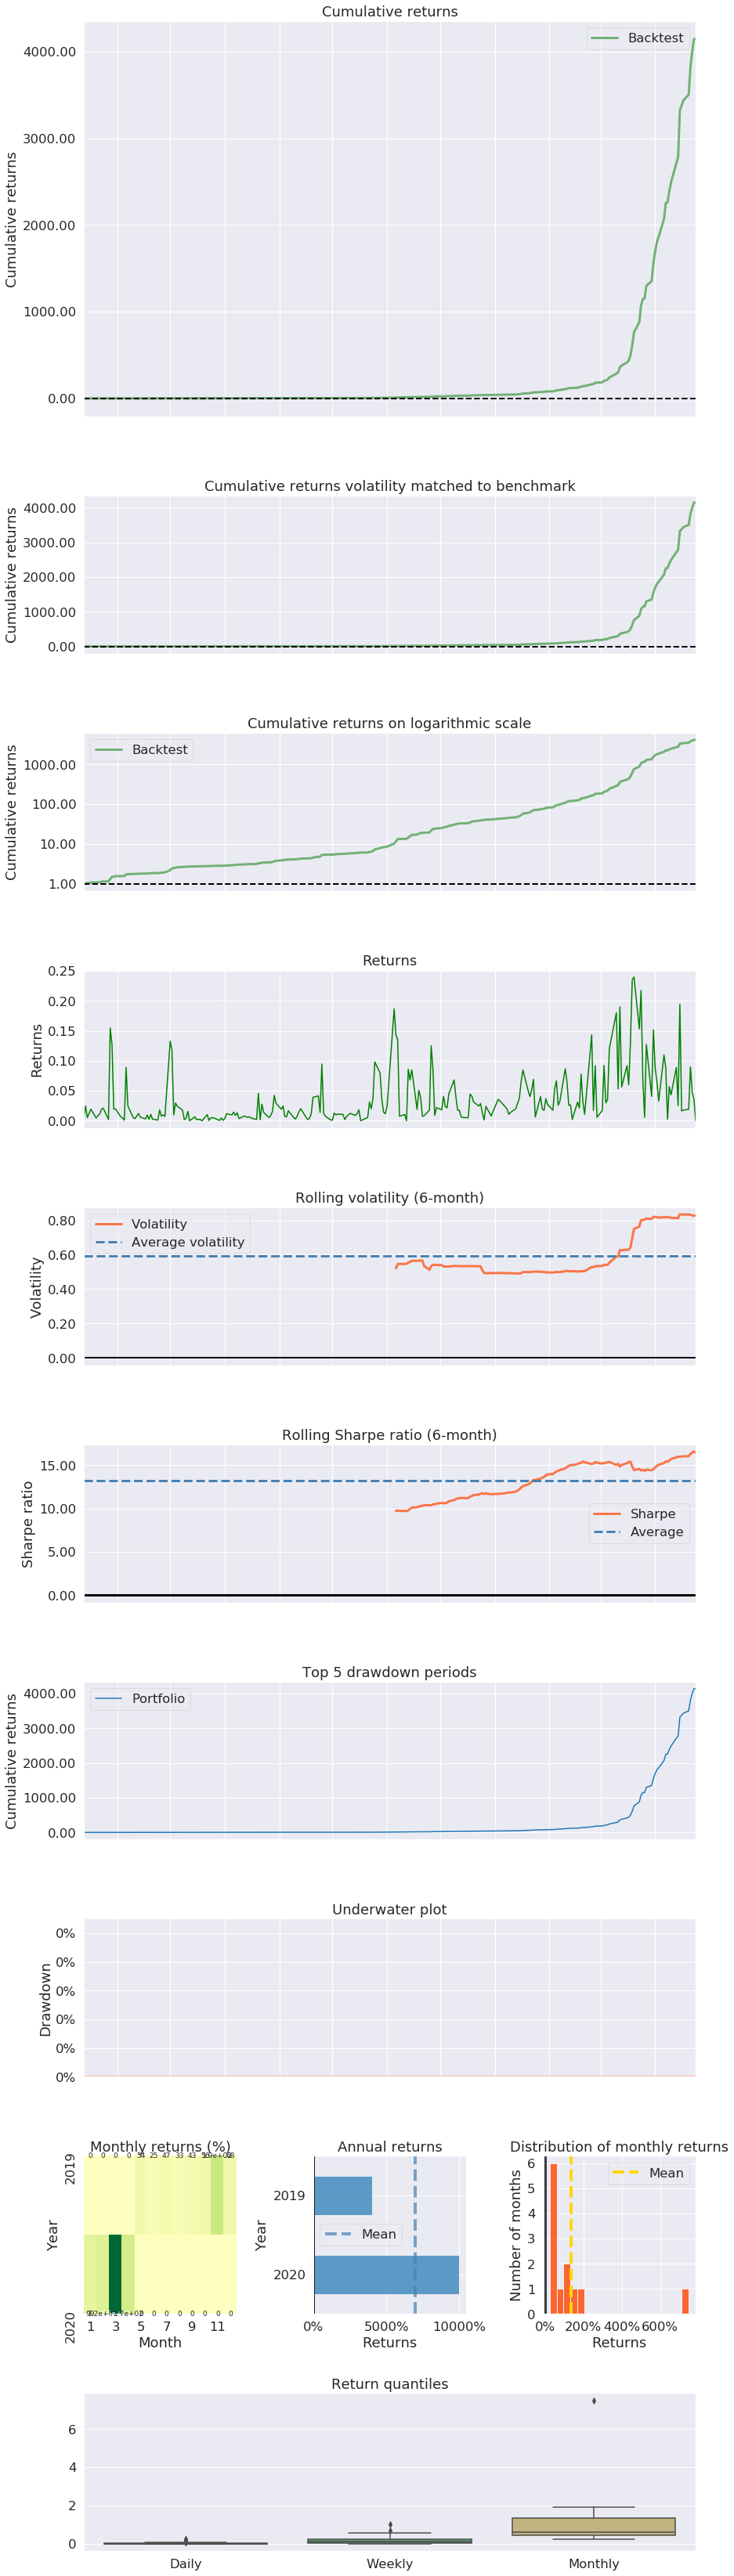

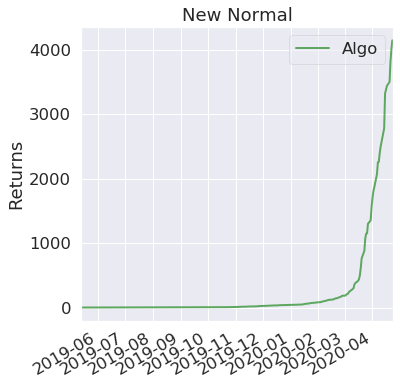

In [55]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis = 1))